In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import os

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Data

I will get the data from the [UCSD covid repo](https://github.com/UCSD-AI4H/COVID-CT) from CT with COVID pacients and non COVID pacients.

In [ ]:
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
!unzip CT_COVID.zip?raw=true
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip?raw=true
!unzip CT_NonCOVID.zip?raw=true
clear_output()

covid_dir = "CT_COVID/"
noncovid_dir = "CT_NonCOVID/"

assert os.listdir(covid_dir) != [], "Data for the covid directory not imported"
assert os.listdir(noncovid_dir) != [], "Data for the noncovid directory not imported"
print("Everything Worked!")

Data pipeline is adapted from the [keras.io examples](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [ ]:
covid_dir = "CT_COVID/"
noncovid_dir = "CT_NonCOVID/"

img_size = (160, 160)

img_paths_covid = sorted(
        [
        os.path.join(covid_dir, fname)
        for fname in os.listdir(covid_dir)
        if fname.endswith(".png")
        ])

img_paths_noncovid = sorted(
        [
        os.path.join(noncovid_dir, fname)
        for fname in os.listdir(noncovid_dir)
        if fname.endswith(".png")
        ])


print(f"Number of samples with COVID: {len(img_paths_covid)}")
print(f"Number of samples without COVID: {len(img_paths_noncovid)}")

# Merging all data
all_paths = img_paths_covid + img_paths_noncovid
print(f"Number of total samples: {len(all_paths)}")

Number of samples with COVID: 349
Number of samples without COVID: 195
Number of total samples: 544


Let's show an example

## With covid

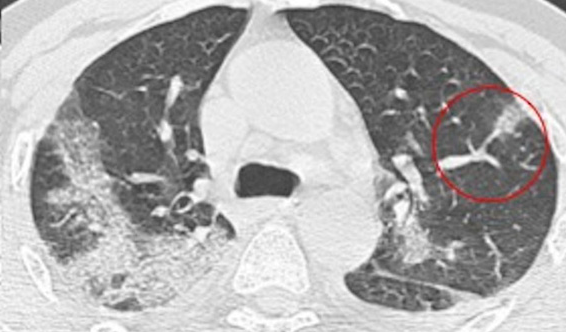

## Without covid

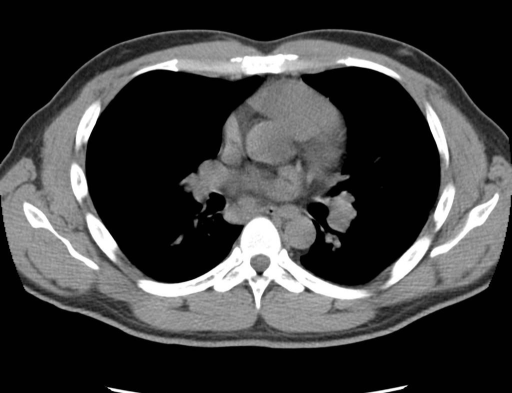

In [ ]:
from IPython.display import Image, display, Markdown
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

index = 1
display(Markdown('## With covid'))
display(Image(filename=img_paths_covid[index]))

display(Markdown('## Without covid'))
display(Image(filename=img_paths_noncovid[index]))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

class Covid(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths        

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.full((batch_size,1), 0)
        for j, path in enumerate(batch_input_img_paths):
          if path[:4] == "CT_N":
            y[j] = 1          
        return x, y

In [ ]:
import random

# Split our img paths into a training and a validation set
batch_size = 32

# validation_split = 0.1
# val_samples = int(validation_split*len(all_paths))

# I'll do this in order to match the output of the prediction
times_batchsize = 3
val_samples = batch_size*3 

random.Random(42).shuffle(all_paths)
train_paths = all_paths[val_samples:]
val_paths = all_paths[:val_samples]

# Instantiate data Sequences for each split
train_gen = Covid(batch_size, img_size, train_paths)
val_gen = Covid(batch_size, img_size, val_paths)

print(f"Validation Split: {np.round(val_samples/len(all_paths),3)}")

Validation Split: 0.176


## Model

In [ ]:
# ResNet Model
res_net = tf.keras.applications.ResNet50(input_shape = (160, 160, 3), include_top = False)
flat = tf.keras.layers.Flatten()(res_net.output)
y_hat = tf.keras.layers.Dense(1, activation = "sigmoid")(flat)
# y_hat = tf.keras.layers.Dense(2, activation = "softmax")(flat)
model = tf.keras.models.Model(res_net.input, y_hat)

### Metrics
Based on [stackoverflow question](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model).

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", 
              metrics = ["accuracy", recall_m, precision_m, f1_m])

# model.compile(optimizer = "adam", loss = "categorical_crossentropy", 
#               metrics = ["accuracy"])

## Training

In [ ]:
epochs = 10
history = model.fit(train_gen,
                validation_data=val_gen, 
                epochs=epochs)

Epoch 1/10
14/14 [==============================] - 4s 320ms/step - loss: 1.4636 - accuracy: 0.7768 - recall_m: 0.6984 - precision_m: 0.6086 - f1_m: 0.6148 - val_loss: 11554672.0000 - val_accuracy: 0.6458 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/10
14/14 [==============================] - 3s 249ms/step - loss: 0.3768 - accuracy: 0.8817 - recall_m: 0.9006 - precision_m: 0.8080 - f1_m: 0.8374 - val_loss: 88260072.0000 - val_accuracy: 0.6458 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/10
14/14 [==============================] - 3s 244ms/step - loss: 0.1966 - accuracy: 0.9353 - recall_m: 0.9249 - precision_m: 0.9105 - f1_m: 0.9152 - val_loss: 161732.2969 - val_accuracy: 0.6458 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/10
14/14 [==============================] - 3s 242ms/step - loss: 0.2230 - accuracy: 0.9554 - recall_m: 0.9353 - precision_m: 0.9373 - f1_m

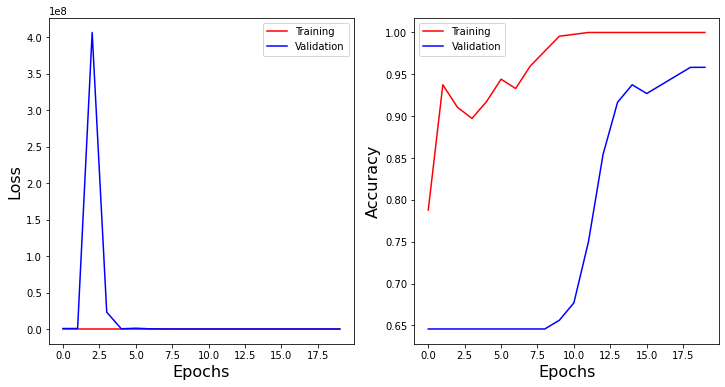

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

In [ ]:
# Generate predictions for all images in the validation set

val_gen = Covid(batch_size, img_size, val_paths)
val_preds = model.predict(val_gen)


Y = np.full((len(val_paths),1), 0)
for id, paths in enumerate(val_paths):
  if paths[:4] == "CT_N":
    Y[id] = 1

-------------------------------------------